In [1]:
import pandas as pd
import numpy as np
from math import sqrt

# Visuals
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot

# T-test
from scipy.stats import anderson
from scipy import stats

# # ANOVA
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# import statsmodels.stats.multicomp as mc

# Power Analysis
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.power import TTestPower

# ANCOVA
from pingouin import ancova
# pd.options.display.max_columns = None #show all columns in data

# Logistic Regression
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import statsmodels.api as sm
import matplotlib.pyplot as plt

# assumption check
from scipy.stats import anderson
import scipy.stats as stats

In [2]:
data = pd.read_csv('Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv')
data

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,Youth_at_arrest__under_18_years,ArrestLocDiv,...,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId
0,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,1
1,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2
2,2020,Oct-Dec,1029922,6057065.0,326622,Unknown or Legacy,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,3
3,2021,Jan-Mar,1052190,6029059.0,327535,Black,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4
4,2021,Jan-Mar,1015512,6040372.0,327535,South Asian,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65271,2021,Oct-Dec,1055609,6044336.0,316123,Indigenous,F,Aged 25 to 34 years,Not a youth,XX,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,65272
65272,2021,Oct-Dec,1032758,6031692.0,307736,South Asian,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65273
65273,2021,Oct-Dec,1021067,6064396.0,324057,White,F,Aged 45 to 54 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65274
65274,2021,Oct-Dec,1008998,6008662.0,331870,Unknown or Legacy,M,Aged 17 years and under,Youth (aged 17 years and under),XX,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,65275


In [3]:
# Data Cleaning
data.loc[data.Age_group__at_arrest_ == 'Aged 17 years and under', 'Age_group__at_arrest_'] = 'Aged 17 years and younger'
data.loc[data.Age_group__at_arrest_ == 'Aged 65 and older', 'Age_group__at_arrest_']= 'Aged 65 years and older'
data['Num_of_Actions'] = data['Actions_at_arrest___Concealed_i'] + data['Actions_at_arrest___Combative__'] + data['Actions_at_arrest___Resisted__d'] + data['Actions_at_arrest___Mental_inst'] + data['Actions_at_arrest___Assaulted_o'] 
data = data[data.Sex != 'U']
data = data[data.Perceived_Race != 'Unknown or Legacy']
data

search_race_action = data.iloc[:, [0, 1, 3, 5, 6, 7, 9, 10, 11, 25]]
search_race_action
search_race_action.columns = ['Year', 'Month', 'ArrestID', 'Race', 'Sex', 'Age', 'Division', 'StripSearch', 'Booked', 'Num_of_Actions']

search_race_action = search_race_action.dropna(how='any')
search_race_action.dropna(how='any', inplace=True)
    
### Some features can be remove here ###
search_race_action_table = search_race_action.groupby(['Year', 'Month', 'Race', 'Sex', 'Age', 'Division']).agg(
    StripSearch_Count = pd.NamedAgg(column = 'StripSearch', aggfunc = 'count'), Mean_of_Actions = pd.NamedAgg(column = 'Num_of_Actions', aggfunc = 'mean'))
search_race_action_table

# Get the data
search_data = search_race_action_table.reset_index()
search_data

,Year,Month,Race,Sex,Age,Division,StripSearch_Count,Mean_of_Actions
0,2020,Apr-June,Black,F,Aged 17 years and younger,11,2,0.500000
1,2020,Apr-June,Black,F,Aged 17 years and younger,12,1,0.000000
2,2020,Apr-June,Black,F,Aged 17 years and younger,13,1,0.000000
3,2020,Apr-June,Black,F,Aged 17 years and younger,31,2,0.000000
4,2020,Apr-June,Black,F,Aged 17 years and younger,33,2,0.000000
...,...,...,...,...,...,...,...,...
7019,2021,Oct-Dec,White,M,Aged 65 years and older,52,3,0.333333
7020,2021,Oct-Dec,White,M,Aged 65 years and older,53,2,0.500000
7021,2021,Oct-Dec,White,M,Aged 65 years and older,54,1,0.000000
7022,2021,Oct-Dec,White,M,Aged 65 years and older,55,1,0.000000


In [4]:
# Create racial groups from dataset 
# creating two different datasets: white and people of color

# Data Cleaning
white = search_data[search_data['Race'] == 'White']
color = search_data[search_data['Race'].isin(['Black', 'East/Southeast Asian', 'Indigenous', 'Latino', 'Middle-Eastern', 'South Asian'])]
white_StripSearch_Count = white['StripSearch_Count']
color_StripSearch_Count = color['StripSearch_Count']

# T-test: Strip Search Frequency vs. Race

In [5]:
print(np.mean(white_StripSearch_Count))
print(np.mean(color_StripSearch_Count))
stats.ttest_ind(white_StripSearch_Count, color_StripSearch_Count, equal_var = False)

16.155202821869487
6.064437347360511


Ttest_indResult(statistic=10.295162784997233, pvalue=3.2145396409433256e-24)

# Power Analysis for Variable Race (without the Unknown/Legacy group)

In [6]:
# Power Analysis

# Code for Cohen's D 
# Function to calculate the pooled standard deviation of 2 samples
def pooled_standard_deviation(sample1,sample2):
    #calculate the sample size
    n1, n2 = len(sample1), len(sample2)
    #calculate the variances
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)
    #calculate the pooled standard deviation
    numerator = ((n1-1) * var1) + ((n2-1) * var2)
    denominator = n1+n2-2
    return np.sqrt(numerator/denominator)

# function to calculate Cohen's d for independent samples
def Cohens_d(sample1, sample2):
    u1, u2 = np.mean(sample1), np.mean(sample2)
    s_pooled = pooled_standard_deviation(sample1, sample2)
    #print(s_pooled)
    return ((u1 - u2) / s_pooled)

In [7]:
# perform power analysis
search_race_effect_size = Cohens_d(white_StripSearch_Count, color_StripSearch_Count)
alpha = 0.05
power = 0.8
ratio_race =len(white_StripSearch_Count)/len(color_StripSearch_Count) #NB: ratio = nobs2/nobs1
print('Effect size (Cohen\'s D) for search frequency:',search_race_effect_size)


Effect size (Cohen's D) for search frequency: 0.42355503961821633


In [8]:
search_race_analysis = TTestIndPower()
search_race_sample_size = search_race_analysis.solve_power(search_race_effect_size, power=power, nobs1=None, ratio=ratio_race, alpha=alpha)
print('Sample Size of nobs1: %.3f' % search_race_sample_size, 'needed for color_StripSearch_Count') 
print('Actual size of color_StripSearch_Count:', len(color_StripSearch_Count))
nobs2 =ratio_race *search_race_sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for white_StripSearch_Count')
print('Actual size of white_StripSearch_Count:', len(white_StripSearch_Count))

Sample Size of nobs1: 182.129 needed for color_StripSearch_Count
Actual size of color_StripSearch_Count: 5323
Sample Size of nobs2: 58.201 needed for white_StripSearch_Count
Actual size of white_StripSearch_Count: 1701


In [9]:
# Check the power of current sample sizes
search_race_power = TTestPower()
color_n_test = search_race_power.solve_power(nobs = 5323, effect_size = 0.8, power = None, alpha = 0.05)
print('Power: {:.3f}'.format(color_n_test))

white_n_test = search_race_power.solve_power(nobs = 1701, effect_size = 0.8, power = None, alpha = 0.05)
print('Power: {:.3f}'.format(white_n_test))

Power: 1.000
Power: 1.000


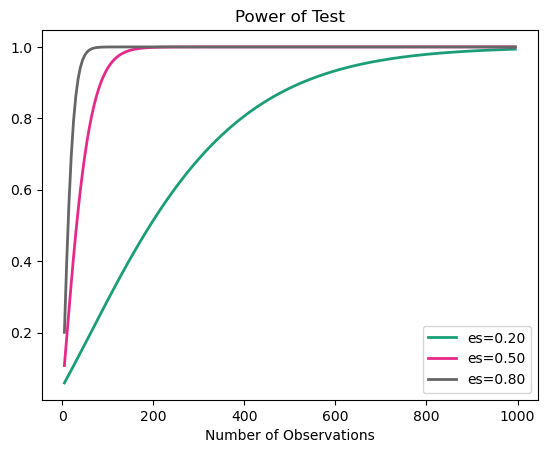

In [10]:
# Power curve

effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, 1000, 5))
  
# plot power curves
search_race_analysis.plot_power(dep_var='nobs', nobs=sample_sizes,
               effect_size=effect_sizes)
  
plt.show()

# Exploratory Data Analysis

## 1. Barplot of strip search incidence for racial groups by gender

In [11]:
search_race_action = search_data.loc[:, ['StripSearch_Count', 'Sex', 'Race', 'Age', 'Mean_of_Actions']]
search_race_action['Race'] = np.where(search_race_action['Race'] != 'White', 'Color', 'White')

In [12]:
search_race_action.Sex.value_counts()

M    4635
F    2389
Name: Sex, dtype: int64

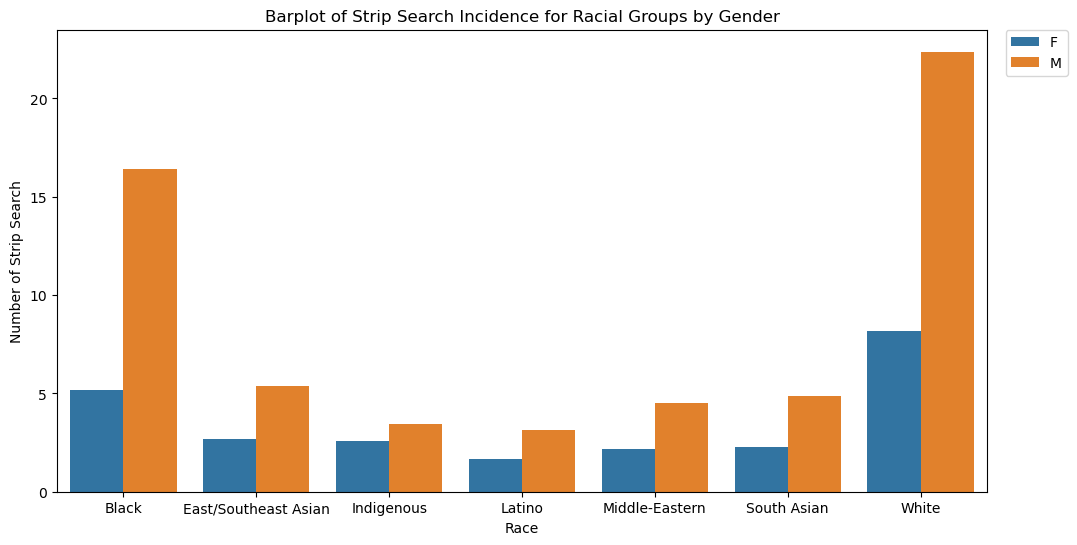

In [13]:
# draw the barplot using 'sns' package

fig,ax = plt.subplots(figsize=(12,6))
Search_d1 = sns.barplot(x = "Race", y = "StripSearch_Count", hue = "Sex", errorbar=None, data = search_data)
plt.title('Barplot of Strip Search Incidence for Racial Groups by Gender')
plt.legend(bbox_to_anchor = (1.02,1), loc='upper left', borderaxespad=0)
Search_d1.set(ylabel='Number of Strip Search')
plt.show()

## Barplot of mean of actions for age groups by gender

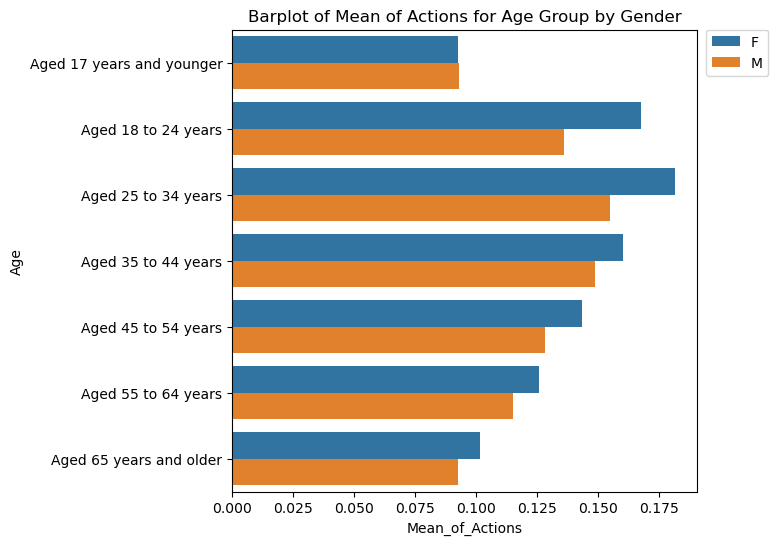

In [14]:
fig,ax = plt.subplots(figsize=(6,6))
Search_d2 = sns.barplot(x = "Mean_of_Actions", y = "Age", hue = "Sex", errorbar=None, data = search_race_action)
plt.title('Barplot of Mean of Actions for Age Group by Gender')
plt.legend(bbox_to_anchor = (1.02,1), loc='upper left', borderaxespad=0)
Search_d1.set(ylabel='Mean of Actions')
plt.show()

## Histogram of mean of actions

In [15]:
# mean_action = search_data["Mean_of_Actions"]

## Histogram of mean of actions by race

In [16]:
Color_action = search_race_action[search_race_action['Race'] == 'Color'].loc[:, 'Mean_of_Actions']
White_action = search_race_action[search_race_action['Race'] == 'White'].loc[:, 'Mean_of_Actions']

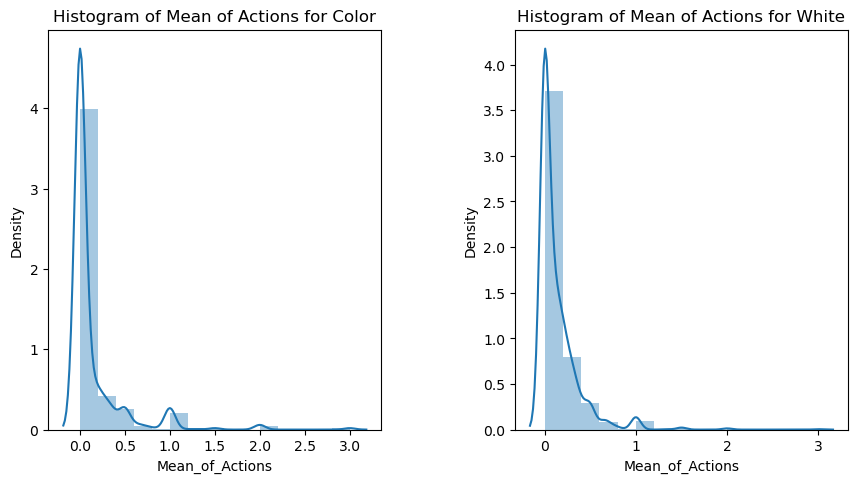

In [17]:
import warnings
warnings.simplefilter('ignore')

    
# option 2: with distribution line
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.distplot(Color_action, bins = 15)
plt.title('Histogram of Mean of Actions for Color')

plt.subplot(1,2,2)
sns.distplot(White_action, bins = 15)
plt.title('Histogram of Mean of Actions for White')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)


## Boxplot of strip search incidence for each age group by gender

(0.0, 100.0)

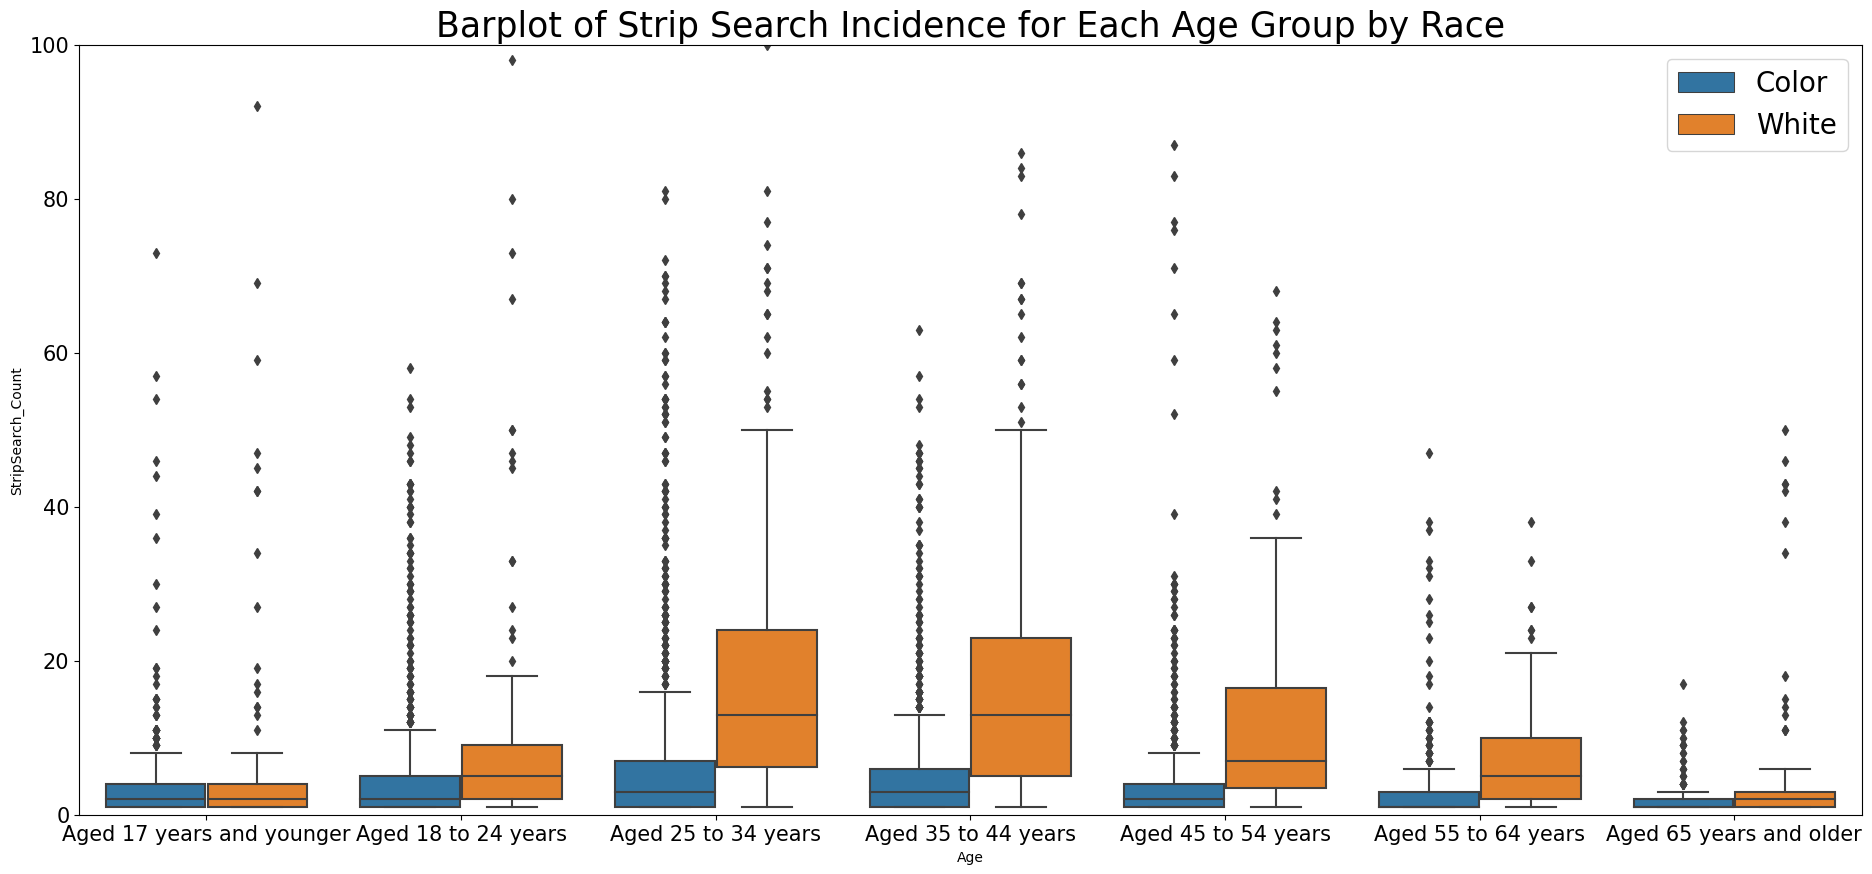

In [18]:
fig,ax = plt.subplots(figsize=(23,10))
sns.boxplot(x = 'Age', y = 'StripSearch_Count', hue = 'Race', data = search_race_action)
plt.title('Barplot of Strip Search Incidence for Each Age Group by Race', fontsize = 25)
plt.legend(fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(top = 100, bottom = 0)

In [19]:
# five assumptions for ANCOVA

# Normality: the dependent variable should be roughly normal for each of category of independent variables.
# Data should show homogeneity of variance.
# The covariate and dependent variable (at each level of independent variable) should be linearly related.
# Your data should be homoscedastic of Y for each value of X.
# The covariate and the independent variable shouldn’t interact. In other words, there should be homogeneity of regression slopes.

# Check five assumptions for ANCOVA for Race

In [20]:
# assumptions of normality

# the residual should be approximately normally distributed
# Use Anderson-Darling Normality test
# Null hypothesis: data is drawn from a normal distribution

res_white = anderson(white_StripSearch_Count)
res_color = anderson(color_StripSearch_Count)

print(res_white.statistic)
print(res_white.critical_values)
print(res_white.significance_level)

print(res_color.statistic)
print(res_color.critical_values)
print(res_color.significance_level)

339.30275018882276
[0.575 0.654 0.785 0.916 1.089]
[15.  10.   5.   2.5  1. ]
1108.4510595598667
[0.576 0.656 0.786 0.917 1.091]
[15.  10.   5.   2.5  1. ]


The test statistic is 340.445. We can compare this value to each critical value that corresponds to each significance level to see if the test result are significant.
\
The critical value for alpha = 0.1 is 1.089. Test result is greater than this critical value, so significant at this level.
\
We can see the test result is significant at every significance level, which means we can reject the null hypothesis. Thus we have sufficient evidence to say that the sample data is not normally distributed.
\
Similar analysis applies to the level of color. We can conclude that the sample data for 2021 is not normally distributed.

In [21]:
# assuption of homogeneity of variance

# option 1: thumb rule

print(np.var(white_StripSearch_Count),np.var(color_StripSearch_Count))
np.var(white_StripSearch_Count)/np.var(color_StripSearch_Count) <= 4

1552.4662119077173 252.64228780572142


False

Population variances are not equal according to the thumb rule of equal variance.

In [22]:
# assumption of homogeneity of variance

# option 2: Use Bartlett's test when the dataset is normally distributed(个人prefer这个方法)
# reference https://www.statology.org/bartletts-test-python/


# Get the data
search_race_action_data = search_race_action_table.reset_index().loc[:, ['StripSearch_Count', 'Race', 'Age', 'Mean_of_Actions']]
search_race_action_data['Race'] = np.where(search_race_action_data['Race'] != 'White', 'Color', 'White')

# # Inspect the data is stored correctly in the sub-dataset
# search_race_action_data.info()

race_action = [search_race_action_data[search_race_action_data['Race'] == 'Color'].loc[:,'Mean_of_Actions'],
               search_race_action_data[search_race_action_data['Race'] == 'White'].loc[:,'Mean_of_Actions']]

# performing Levene's test
# All groups
# test_statistic, p_value = stats.levene(race_action[0], race_action[1], race_action[2], race_action[3], race_action[4], race_action[5], race_action[6])

# Only White and Color groups
test_statistic, p_value = stats.levene(race_action[0], race_action[1])

print(test_statistic, p_value)


0.0762563764475431 0.7824443867697906


Text(0.5, 1.0, 'Scatterplot of Means of Actions and the Number of Strip Search')

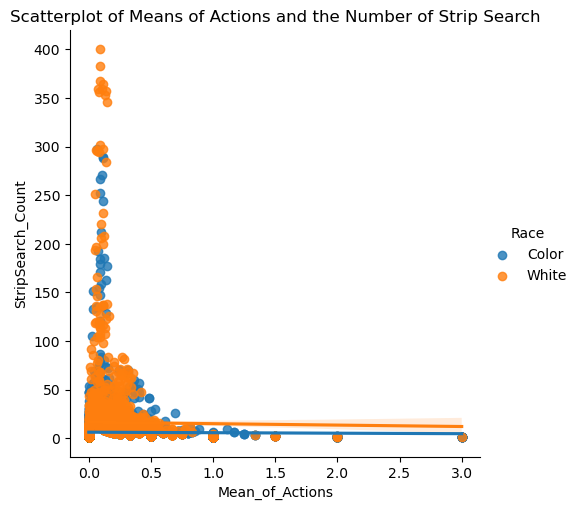

In [23]:
# check linearity assumption
# The relationship between the covariate and the dependent variable should be linear

sns.lmplot(x="Mean_of_Actions",
                    y="StripSearch_Count",
                    data=search_race_action_data, hue = "Race")
plt.title('Scatterplot of Means of Actions and the Number of Strip Search', fontsize = 12)

We get a p-value smaller than 0.05, so we have sufficient evidence to reject the null hypothesis that the variance among each group are equal. 
\
Therefore, the assumption of equal variance is violated.

In [24]:
# Perform ANCOVA test
# Number of StripSearch VS. Race + Mean Number of Actions(Control)
# between could be Race
ancova(data=search_race_action_data, dv='StripSearch_Count', covar='Mean_of_Actions', between='Race')

,Source,SS,DF,F,p-unc,np2
0,Race,1.312154e+05,1,231.167258,2.170098e-51,0.031876
1,Mean_of_Actions,2.911625e+02,1,0.512952,4.738875e-01,0.000073
2,Residual,3.985269e+06,7021,NaN,NaN,NaN


The null hypothesis for this example: People who got arrested for all race/age groups have the same strip search frequency on average after counting their mean number of actions taken during arrests.

# First logistic regression: StripSearch Frequency

In [25]:
# Logistic Regression

# StripSearch ~ Month + Race + Sex + Age + Booked + #ofAction
search_log_data = data.iloc[: , [1, 5, 6, 7, 9, 10, 11, 25]]
search_log_data.columns = ['Month', 'Race', 'Sex', 'Age', 'Division', 'StripSearch', 'Booked', 'Num_of_Actions']

search_log_data.loc[search_log_data['Race'] != 'White', 'Race'] = 'Color'
# search_log_data['Race'] = np.where(search_log_data['Race'] != 'White', 'Color', 'White')

search_log_data = search_log_data.dropna()
search_log_data

# Data cleaning
search_log = search_log_data.copy()

search_X = search_log.drop(['StripSearch', 'Division'], axis=1)
search_y = search_log['StripSearch']
search_X

,Month,Race,Sex,Age,Booked,Num_of_Actions
0,July-Sept,White,M,Aged 35 to 44 years,1,0
1,July-Sept,White,M,Aged 35 to 44 years,1,0
3,Jan-Mar,Color,M,Aged 25 to 34 years,0,0
4,Jan-Mar,Color,M,Aged 25 to 34 years,1,0
5,Apr-June,Color,M,Aged 25 to 34 years,1,0
...,...,...,...,...,...,...
65270,Oct-Dec,White,F,Aged 25 to 34 years,0,0
65271,Oct-Dec,Color,F,Aged 25 to 34 years,0,1
65272,Oct-Dec,Color,M,Aged 35 to 44 years,1,0
65273,Oct-Dec,White,F,Aged 45 to 54 years,0,0


In [26]:
# Split the dataset into training and test sets
search_X_train, search_X_test, search_y_train, search_y_test = train_test_split(search_X , search_y, test_size = 0.2, random_state = 10086)

In [27]:
# Build logistic regression model

# Create the formula string 
all_columns = ' + '.join(search_X)
formula = "StripSearch ~ " + all_columns 
print("Formula: ", formula, "\n")

# Put the training predictors and responses into one DataFrame to be input into the model
search_training_data = pd.concat([search_X_train, search_y_train], axis = 1)

search_logreg = smf.logit(formula = formula, data = search_training_data).fit()

Formula:  StripSearch ~ Month + Race + Sex + Age + Booked + Num_of_Actions 

Optimization terminated successfully.
         Current function value: 0.294687
         Iterations 8


In [28]:
search_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            StripSearch   No. Observations:                48152
Model:                          Logit   Df Residuals:                    48138
Method:                           MLE   Df Model:                           13
Date:                Sat, 15 Apr 2023   Pseudo R-squ.:                  0.2013
Time:                        20:41:07   Log-Likelihood:                -14190.
converged:                       True   LL-Null:                       -17765.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -4.1021      0.099    -41.403      0.000      -4.296      -3.908
Month[T.Jan-Mar]                   0.3134      0.039      8.049      0.000       0.237       0.390
Month[T.July-Sept]                 0.0703      0.040      1.742      0.082      -0.009       0.149
Month[T.Oct-Dec]                  -1.6567      0.062    -26.589      0.000      -1.779      -1.535
Race[T.White]                      0.2241      0.031      7.215      0.000       0.163       0.285
Sex[T.M]                           0.1278      0.041      3.115      0.002       0.047       0.208
Age[T.Aged 18 to 24 years]         0.1314      0.085      1.538      0.124      -0.036       0.299
Age[T.Aged 25 to 34 years]         0.0164      0.082      0.202      0.840      -0.143       0.176
Age[T.Aged 35 to 44 years]         0.0186      0.083      0.224      0.822      -0.144       0.181
Age[T.Aged 45 to 54 years]        -0.2394      0.089     -2.697      0.007      -0.413      -0.065
Age[T.Aged 55 to 64 years]        -0.4555      0.103     -4.428      0.000      -0.657      -0.254
Age[T.Aged 65 years and older]    -1.3363      0.212     -6.295      0.000      -1.752      -0.920
Booked                             2.6846      0.053     50.870      0.000       2.581       2.788
Num_of_Actions                     0.3513      0.027     13.101      0.000       0.299       0.404
==================================================================================================
"""

In [29]:
# Odds Ratio
search_params = search_logreg.params
search_odds_ratio = np.exp(search_params)

# Confidence Interval
search_conf = search_logreg.conf_int()
search_conf['OR'] = search_params
search_conf.columns = ["Lower CI", "Upper CI", "OR"]
search_conf_exp = np.exp(search_conf)
search_conf_exp

,Lower CI,Upper CI,OR
Intercept,0.013619,0.020083,0.016538
Month[T.Jan-Mar],1.267531,1.476540,1.368050
Month[T.July-Sept],0.991225,1.161203,1.072853
Month[T.Oct-Dec],0.168842,0.215551,0.190772
Race[T.White],1.177292,1.329703,1.251179
Sex[T.M],1.048540,1.231502,1.136345
Age[T.Aged 18 to 24 years],0.964566,1.348445,1.140466
Age[T.Aged 25 to 34 years],0.866448,1.192687,1.016563
Age[T.Aged 35 to 44 years],0.865971,1.198566,1.018785
Age[T.Aged 45 to 54 years],0.661434,0.936641,0.787100


Test Accuracy of Logistic Regression : 1

Training Confusion Matrix : 
 [[42275    50]
 [ 5786    41]]

Test Confusion Matrix : 
 [[10588    13]
 [ 1432     6]]


<AxesSubplot: >

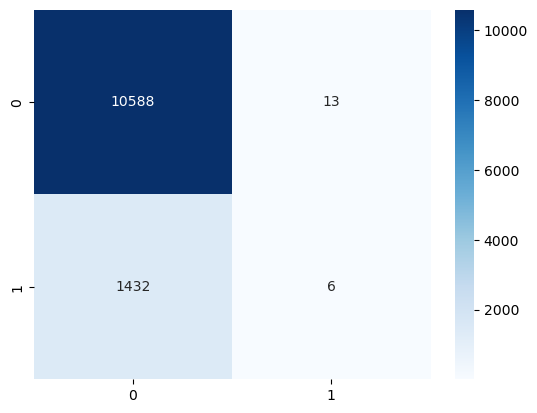

In [30]:
# Predict responses 
search_test_pred = search_logreg.predict(search_X_test)
# round() rounds to nearest integer;
# 0.5 rounds to 0; 0.501 rounds to 1
search_test_pred = list(map(round, search_test_pred))

# Accuracy score
print("Test Accuracy of Logistic Regression : {}".format(round(accuracy_score(search_y_test, search_test_pred), )))

# Prediction on the training set
search_train_pred = search_logreg.predict(search_X_train)
search_train_pred = list(map(round, search_train_pred))

search_train_cm = confusion_matrix(search_y_train, search_train_pred) 
print ("\nTraining Confusion Matrix : \n", search_train_cm)

# Confusion matrix
# C0,0 is TN, C1,0 is FN, C1,1 is TP, C0,1 FP
search_test_cm = confusion_matrix(search_y_test, search_test_pred) 
print ("\nTest Confusion Matrix : \n", search_test_cm) 

# # Plot the test confusion matrix
sns.heatmap(search_test_cm, annot=True, cmap='Blues', fmt='g')

In [31]:
tn, fp, fn, tp = confusion_matrix(search_y_test, search_test_pred).ravel()
(tn, fp, fn, tp)

print('Type I error rate:', round(fp / (fp + tn), 4)*100)
print('Type II error rate:', round(fn / (fn + tp), 4)*100)

Type I error rate: 0.12
Type II error rate: 99.58


Optimization terminated successfully.
         Current function value: 0.363593
         Iterations 6


Text(0.5, 1.0, 'Prediction Interval Plot')

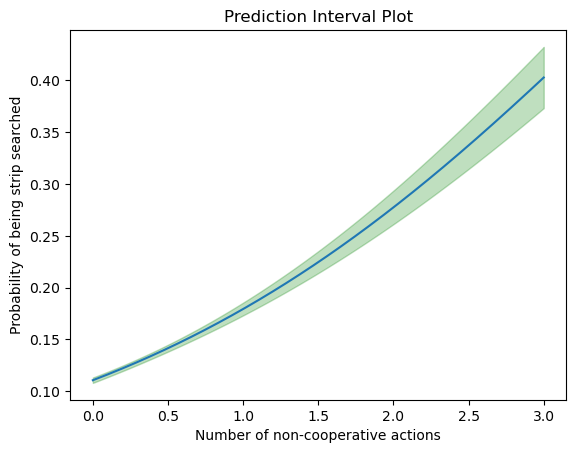

In [32]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import statsmodels.api as sm
pd.options.display.max_rows = 10

search_pred = search_log_data.copy()

search_mod = sm.Logit.from_formula('StripSearch ~ Num_of_Actions', search_pred)
search_res = search_mod.fit()
search_me = search_res.get_margeff()

Λ = lambda x: stats.logistic().cdf(x)
λ = lambda x: stats.logistic().pdf(x)

β_ = search_res.params.values.reshape(-1, 1)
V_ = search_res.cov_params().values

# this is the equation from above for Var(F)
# only works for a single observation though
def var_π(x, β, V_):
    #      λ(z)**s * x.T @ V_ @ x
    prob = λ(x.T.dot(β))**2 * x.T.dot(V_).dot(x)  # maybe this is it?
    return prob

# for multiple observations, but not quite vectorized fully

def var_πs(xx, β, V_):
    α = λ(xx.dot(β))**2
    out = np.empty((500, 1))
    for i, x in enumerate(xx):
        out[i] = x.T.dot(V_).dot(x)
    return α * out

# Making some fake data.
xx = sm.add_constant(np.linspace(search_pred.Num_of_Actions.min(), search_pred.Num_of_Actions.max(), 500).reshape(-1, 1))
πs = Λ(xx.dot(β_))
vv = np.sqrt(var_πs(xx, β_, V_))

plt.plot(xx[:, 1], πs)
plt.fill_between(xx[:, 1], (πs - 1.96*vv).ravel(), (πs + 1.96*vv).ravel(),
                 alpha=.25, color='g')
plt.xlabel('Number of non-cooperative actions')
plt.ylabel('Probability of being strip searched')
plt.title('Prediction Interval Plot')

# Second logistic regression: ItemsFound

There are 7265 cases where people were strip searched.
Among which, items were found in 2716 cases.


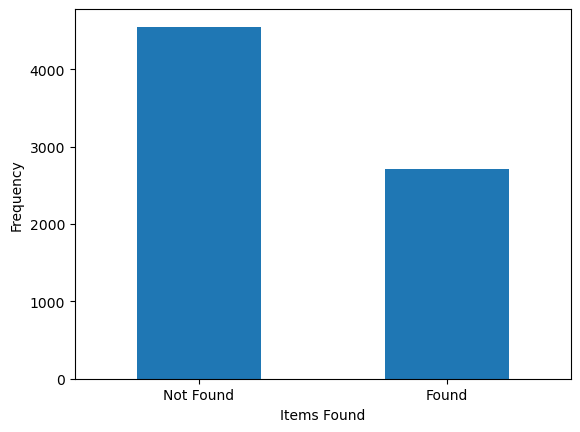

In [33]:
print("There are", len(data[data.StripSearch == 1]), "cases where people were strip searched.")
searched = data[((data.StripSearch == 1) & (data.ItemsFound.notna()))]
searched.ItemsFound.astype('int')
print("Among which, items were found in", len(searched[searched.ItemsFound == 1]), "cases.")

fig, ax = plt.subplots()
searched['ItemsFound'].value_counts().plot(ax=ax, kind='bar', xlabel='Items Found', ylabel='Frequency')
plt.xticks(ticks = [0, 1], labels = ['Not Found','Found'], rotation = 0)
plt.show()

In [34]:
# Logistic Regression
# ItemFound ~ Month + Race + Sex + Age + PrimaryOffences

data['Occurrence_Category'] = data['Occurrence_Category'].str.replace('and', '&')
data['Occurrence_Category'] = np.where(data['Occurrence_Category'] == 'Weapons', 'Weapons & Homicide', data['Occurrence_Category'])
item_log_data = data.loc[(data.Occurrence_Category.isin(['Drug Related', 'Break & Enter', 'Weapons & Homicide']) & data.ItemsFound.notna()), :]
item_log_data = item_log_data.iloc[:, [1, 5, 6, 7, 12, 23]]
# item_log_data['ItemsFound'] = item_log_data['ItemsFound'].astype('int')
# item_log_data['ItemsFound'] = item_log_data['ItemsFound']

item_log_data.columns = ['Month', 'Race', 'Sex', 'Age', 'Offence', 'ItemsFound']
item_log_data['Race'] = np.where(item_log_data['Race'] != 'White', 'Color', 'White')
item_log_data

# Data cleaning
# Ordinal Encoding the categorical variables
item_log = item_log_data.copy()
item_log

item_X = item_log.drop(['ItemsFound'], axis=1)
item_y = item_log['ItemsFound']
item_X

,Month,Race,Sex,Age,Offence
33,Jan-Mar,White,M,Aged 35 to 44 years,Weapons & Homicide
58,Jan-Mar,White,F,Aged 35 to 44 years,Drug Related
69,Jan-Mar,Color,M,Aged 45 to 54 years,Break & Enter
73,Jan-Mar,White,M,Aged 25 to 34 years,Weapons & Homicide
137,July-Sept,White,M,Aged 18 to 24 years,Weapons & Homicide
...,...,...,...,...,...
63141,Oct-Dec,Color,M,Aged 18 to 24 years,Weapons & Homicide
63435,July-Sept,Color,F,Aged 18 to 24 years,Weapons & Homicide
63915,July-Sept,Color,M,Aged 25 to 34 years,Drug Related
64108,Oct-Dec,White,M,Aged 35 to 44 years,Break & Enter


In [35]:
# Check primary offences
distinct_values = item_log_data['Offence'].unique()
print(distinct_values)

['Weapons & Homicide' 'Drug Related' 'Break & Enter']


# EDA for the second logistic regression

## barplot of items found for each offence type by age

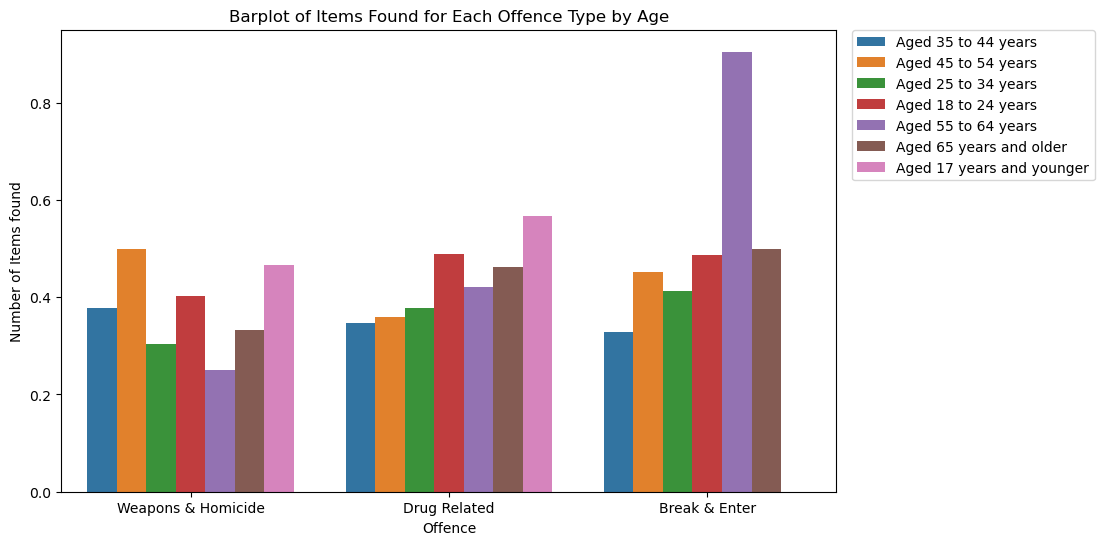

In [36]:
fig,ax = plt.subplots(figsize=(10,6))
Search_d1 = sns.barplot(x = "Offence", y = "ItemsFound", hue = "Age", errorbar=None, data = item_log_data)
plt.title('Barplot of Items Found for Each Offence Type by Age')
plt.legend(bbox_to_anchor = (1.02,1), loc='upper left', borderaxespad=0)
Search_d1.set(ylabel='Number of Items found')
plt.show()

In [37]:
# Split the dataset into training and test sets
item_X_train, item_X_test, item_y_train, item_y_test = train_test_split(item_X, item_y, test_size = 0.2, random_state = 10086)

In [38]:
# Build logistic regression model

# Create the formula string 
all_columns = ' + '.join(item_X)
formula = "ItemsFound ~ " + all_columns 
print("Formula: ", formula, "\n")

# Put the training predictors and responses into one DataFrame to be input into the model
item_training_data = pd.concat([item_X_train, item_y_train], axis = 1)
item_training_data

item_logreg = smf.logit(formula = formula, data = item_training_data).fit()
item_logreg.summary()

Formula:  ItemsFound ~ Month + Race + Sex + Age + Offence 

Optimization terminated successfully.
         Current function value: 0.658345
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             ItemsFound   No. Observations:                 1522
Model:                          Logit   Df Residuals:                     1508
Method:                           MLE   Df Model:                           13
Date:                Sat, 15 Apr 2023   Pseudo R-squ.:                 0.02226
Time:                        20:41:08   Log-Likelihood:                -1002.0
converged:                       True   LL-Null:                       -1024.8
Covariance Type:            nonrobust   LLR p-value:                 1.651e-05
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.5645      0.346      1.630      0.103      -0.114       1.243
Month[T.Jan-Mar]                  -0.1022      0.139     -0.733      0.464      -0.376       0.171
Month[T.July-Sept]                -0.0410      0.139     -0.294      0.768      -0.314       0.232
Month[T.Oct-Dec]                  -0.7690      0.222     -3.457      0.001      -1.205      -0.333
Race[T.White]                      0.0780      0.119      0.656      0.512      -0.155       0.311
Sex[T.M]                          -0.3540      0.153     -2.317      0.021      -0.654      -0.055
Age[T.Aged 18 to 24 years]        -0.2141      0.289     -0.741      0.459      -0.781       0.353
Age[T.Aged 25 to 34 years]        -0.6727      0.286     -2.355      0.019      -1.232      -0.113
Age[T.Aged 35 to 44 years]        -0.7625      0.293     -2.604      0.009      -1.336      -0.189
Age[T.Aged 45 to 54 years]        -0.4660      0.319     -1.459      0.145      -1.092       0.160
Age[T.Aged 55 to 64 years]         0.2411      0.391      0.617      0.537      -0.525       1.007
Age[T.Aged 65 years and older]    -0.0885      0.570     -0.155      0.877      -1.206       1.029
Offence[T.Drug Related]           -0.0513      0.137     -0.374      0.708      -0.320       0.217
Offence[T.Weapons & Homicide]     -0.2331      0.165     -1.417      0.157      -0.556       0.089
==================================================================================================
"""

In [39]:
# Odds Ratio
item_params = item_logreg.params
item_odds_ratio = np.exp(item_params)

# Confidence Interval
item_conf = item_logreg.conf_int()
item_conf['OR'] = item_params
item_conf.columns = ["Lower CI", "Upper CI", "OR"]
item_conf_exp = np.exp(item_conf)
# item_conf_exp
pd.set_option('display.max_rows', None)
item_conf_exp

,Lower CI,Upper CI,OR
Intercept,0.891971,3.466952,1.758528
Month[T.Jan-Mar],0.686922,1.186645,0.902847
Month[T.July-Sept],0.730342,1.261318,0.959788
Month[T.Oct-Dec],0.299702,0.716735,0.463473
Race[T.White],0.856414,1.364759,1.081110
Sex[T.M],0.520198,0.946926,0.701847
Age[T.Aged 18 to 24 years],0.458053,1.422663,0.807252
Age[T.Aged 25 to 34 years],0.291579,0.893265,0.510351
Age[T.Aged 35 to 44 years],0.262799,0.828033,0.466483
Age[T.Aged 45 to 54 years],0.335560,1.173543,0.627530


Test Accuracy of Logistic Regression : 0.5958

Training Confusion Matrix : 
 [[833  79]
 [524  86]]

Test Confusion Matrix : 
 [[210  28]
 [126  17]]


<AxesSubplot: >

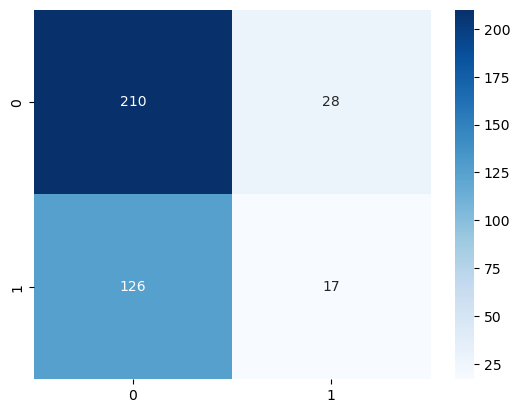

In [40]:
# Assess the result
# Predict responses 
item_test_pred = item_logreg.predict(item_X_test)
# round() rounds to nearest integer;
# 0.5 rounds to 0; 0.501 rounds to 1
item_test_pred = list(map(round, item_test_pred))

# Accuracy score
print("Test Accuracy of Logistic Regression : {}".format(round(accuracy_score(item_y_test, item_test_pred), 5)))

# Prediction on the training set
item_train_pred = item_logreg.predict(item_X_train)
item_train_pred = list(map(round, item_train_pred))

item_train_cm = confusion_matrix(item_y_train, item_train_pred) 
print ("\nTraining Confusion Matrix : \n", item_train_cm)

# Confusion matrix
# C0,0 is TN, C1,0 is FN, C1,1 is TP, C0,1 FP
item_test_cm = confusion_matrix(item_y_test, item_test_pred) 
print ("\nTest Confusion Matrix : \n", item_test_cm) 

# Plot the test confusion matrix
sns.heatmap(item_test_cm, annot=True, cmap='Blues', fmt='g')

In [41]:
tn, fp, fn, tp = confusion_matrix(item_y_test, item_test_pred).ravel()
(tn, fp, fn, tp)

print('Type I error rate:', round(fp / (fp + tn), 4)*100)
print('Type II error rate:', round(fn / (fn + tp), 4)*100)

Type I error rate: 11.76
Type II error rate: 88.11


Optimization terminated successfully.
         Current function value: 0.671120
         Iterations 4


Text(0.5, 1.0, 'Prediction Interval Plot')

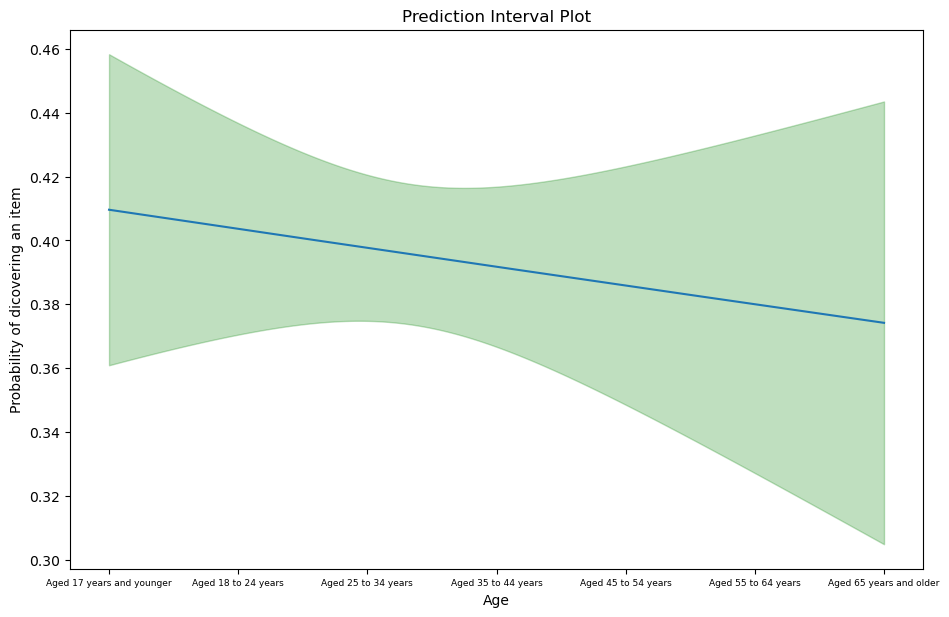

In [42]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import statsmodels.api as sm
pd.options.display.max_rows = 10

item_pred = item_log_data.copy()
item_pred.Age.unique()

item_pred.loc[item_pred['Age'] == 'Aged 17 years and younger', 'Age'] = 0
item_pred.loc[item_pred['Age'] == 'Aged 18 to 24 years', 'Age'] = 1
item_pred.loc[item_pred['Age'] == 'Aged 25 to 34 years', 'Age'] = 2
item_pred.loc[item_pred['Age'] == 'Aged 35 to 44 years', 'Age'] = 3
item_pred.loc[item_pred['Age'] == 'Aged 45 to 54 years', 'Age'] = 4
item_pred.loc[item_pred['Age'] == 'Aged 55 to 64 years', 'Age'] = 5
item_pred.loc[item_pred['Age'] == 'Aged 65 years and older', 'Age'] = 6


label_encoder = LabelEncoder()
item_pred['Age'] = label_encoder.fit_transform(item_pred["Age"])
item_pred

item_mod = sm.Logit.from_formula('ItemsFound ~ Age', item_pred)
item_res = item_mod.fit()
item_me = item_res.get_margeff()

Λ = lambda x: stats.logistic().cdf(x)
λ = lambda x: stats.logistic().pdf(x)

β_ = item_res.params.values.reshape(-1, 1)
V_ = item_res.cov_params().values

# this is the equation from above for Var(F)
# only works for a single observation though
def var_π(x, β, V_):
    #      λ(z)**s * x.T @ V_ @ x
    prob = λ(x.T.dot(β))**2 * x.T.dot(V_).dot(x)  # maybe this is it?
    return prob

# for multiple observations, but not quite vectorized fully

def var_πs(xx, β, V_):
    α = λ(xx.dot(β))**2
    out = np.empty((500, 1))
    for i, x in enumerate(xx):
        out[i] = x.T.dot(V_).dot(x)
    return α * out

# Making some fake data.
xx = sm.add_constant(np.linspace(item_pred.Age.min(), item_pred.Age.max(), 500).reshape(-1, 1))
πs = Λ(xx.dot(β_))
vv = np.sqrt(var_πs(xx, β_, V_))


item_x = ['Aged 17 years and younger', 'Aged 18 to 24 years', 'Aged 25 to 34 years', 'Aged 35 to 44 years', 'Aged 45 to 54 years', 'Aged 55 to 64 years', 'Aged 65 years and older']
age_x_ticks = range(len(item_x))

plt.rcParams['figure.figsize'] = [11, 7]
plt.plot(xx[:, 1], πs)
plt.fill_between(xx[:, 1], (πs - 1.96*vv).ravel(), (πs + 1.96*vv).ravel(), alpha=.25, color='g')
plt.xticks(age_x_ticks, item_x, fontsize = 6.5)
plt.xlabel('Age')
plt.ylabel('Probability of dicovering an item')
plt.title('Prediction Interval Plot')